In [1]:
import math
from torch.optim.lr_scheduler import _LRScheduler
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

---

## Implementing the warmup-constant-decay scheduler using the OLMo scheduler class and interface

In [2]:
from dataclasses import dataclass
from typing import Optional, Literal
from math import pi, cos, sqrt

from olmo.optim import Scheduler

In [3]:
@dataclass
class CustomScheduler(Scheduler):
    warmup_steps: int
    decay_steps: int
    decay_type: Literal['linear', 'cosine', 'sqrt']
    grad_clip_warmup_steps: Optional[int]
    grad_clip_warmup_factor: Optional[float]
    warmup_min_lr: Optional[float]

    def _decay_function(self, x: float) -> float:
        """Calculate decay factor based on selected decay type."""
        if self.decay_type == 'linear':
            return 1 - x
        elif self.decay_type == 'cosine':
            return (1 + cos(pi * x)) / 2
        else:  # sqrt
            return 1 - sqrt(x)

    def get_lr(self, initial_lr: float, step: int, max_steps: int) -> float:
        """
        Compute learning rate for current step.
        
        Args:
            initial_lr: Base learning rate.
            step: Current training step.
            max_steps: Total number of training steps.
        
        Returns:
            float: Learning rate for current step.
        """
        if step < self.warmup_steps:
            # Warmup phase - use parent class's linear warmup implementation
            return self._linear_warmup(initial_lr, step, self.warmup_steps)
        
        elif step <= max_steps - self.decay_steps:
            # Constant phase
            return initial_lr
        
        elif step < max_steps:
            # Decay phase
            x = (step - (max_steps - self.decay_steps)) / self.decay_steps
            decay_factor = self._decay_function(x)
            return initial_lr * decay_factor
        
        else:
            # After max_steps, maintain the final learning rate
            x = 1.0
            decay_factor = self._decay_function(x)
            return initial_lr * decay_factor

In [15]:
lrs = {}
for decay_type in ['linear', 'cosine', 'sqrt']:
    # Create scheduler
    scheduler = CustomScheduler(
        warmup_steps=20,
        decay_steps=30,
        decay_type=decay_type,
        grad_clip_warmup_steps=None,
        grad_clip_warmup_factor=None,
        warmup_min_lr=None
    )

    # Generate learning rates
    initial_lr = 0.1
    max_steps = 100
    lrs[decay_type] = [scheduler.get_lr(initial_lr, step, max_steps) for step in range(max_steps)]


In [16]:
# plt.style.available

ggplot


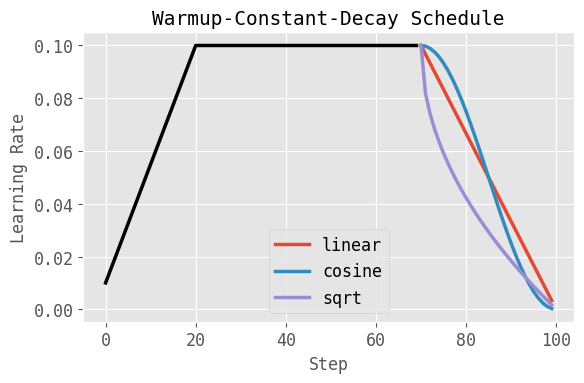

In [29]:
# Plot

max_steps = 100
decay_steps = 30

for style in ["ggplot"]:
    print(style)
    with plt.style.context([style, {
        'font.size': 12,
        'font.family': 'monospace'
    }]):
        fig, axes = plt.subplots(1, 1, figsize=(6, 4))

        # plot until the decay phase
        axes.plot(lrs['linear'][:max_steps-decay_steps], linewidth=2.5, color='black')

        # plot decay phase
        for decay_type in ['linear', 'cosine', 'sqrt']:
            axes.plot(range(max_steps-decay_steps, max_steps), lrs[decay_type][-decay_steps:], linewidth=2.5, label=decay_type)
        
        axes.set_title(r'Warmup-Constant-Decay Schedule', fontsize=14)
        axes.set_xlabel(r'Step', fontsize=12)
        axes.set_ylabel(r'Learning Rate', fontsize=12)
        axes.grid(True)
        axes.legend(loc='best')
        plt.tight_layout()
        plt.show()
        plt.close()

In [26]:
# # Get all settings for a specific style
# style_name = 'ggplot'
# style_dict = plt.style.library[style_name]
# print(f"Settings for {style_name}:")
# for key, value in style_dict.items():
#     print(f"{key}: {value}")

In [27]:
# # Get font settings only
# font_settings = {k: v for k, v in style_dict.items() if 'font' in k}
# print("\nFont settings:")
# for key, value in font_settings.items():
#     print(f"{key}: {value}")